# Feature Extraction: Edges

# Table of Contents:


1.   Setup
2.   Load Data
3.   Quick EDA
4.   Feature Extraction: Edge Detection
5.   PCA
6.   Predictive Power
7.   TSNE (WIP)
8.   K Means (WIP)


## Setup

In [1]:
!pip install webdataset

In [11]:
#import libraries
import webdataset as wds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2 as cv

from skimage import feature
from skimage import data, exposure
from skimage import filters

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression

import seaborn as sns



In [3]:
# paths
root = '/content/drive/My Drive/DS 281 - CV/2024-11-05 pull 281_Final-main/'
data_folder = f'{root}/data'
feature_data_folder = f'{root}/feature_data'

# Google Drive
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/DS 281 - CV/2024-11-05 pull 281_Final-main')

ModuleNotFoundError: No module named 'google'

In [2]:
#alternate paths
root = '.'
data_folder = f'{root}/data'
feature_data_folder = f'{root}/data'

## Load Data

In [3]:
def load_data(path_to_data: str):
    """
    load 2D images and their labels

    returns: 
    images (array): array of images as np arrays
    labels (array): array of labels
    """
    #create lists to store images and labels
    images = []
    labels = []

    #load webdataset
    data = (wds.WebDataset(f'{path_to_data}', shardshuffle=True)
        .decode("pil")
        .to_tuple("jpg", "json")
        .map(lambda row: (np.array(row[0]), row[1]['label'])))

    #append dataset to lists
    for image, label in data:
        images.append(image)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)
    data.close()

    return images, labels

In [4]:
train_images, train_labels = load_data(f'file:{data_folder}/train-000000.tar')
val_images, val_labels = load_data(f'file:{data_folder}/val-000000.tar')
test_images, test_labels = load_data(f'file:{data_folder}/test-000000.tar')

7


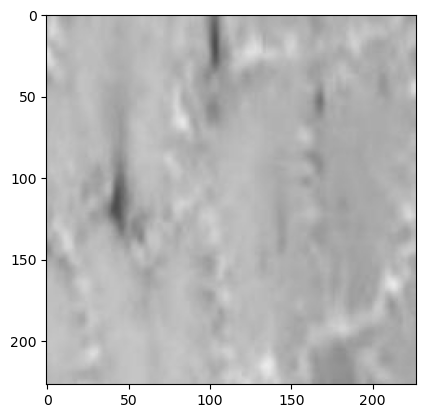

In [5]:
print(train_labels[0])
plt.imshow(train_images[0])

In [6]:
print("Shape of images:", train_images.shape)
print("Shape of labels:", train_labels.shape)

Shape of images: (8960, 227, 227, 3)
Shape of labels: (8960,)


## Quick EDA

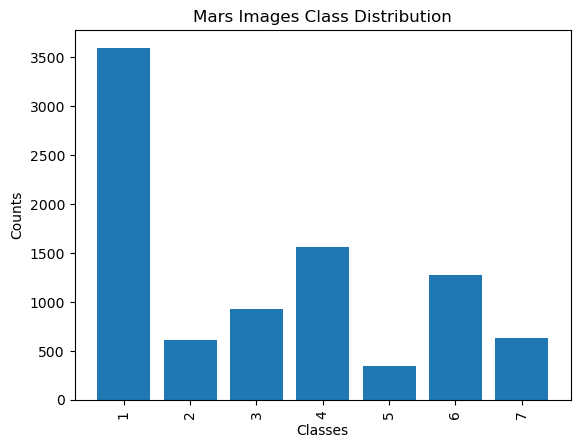

In [7]:
unique, counts = np.unique(train_labels, return_counts=True)
class_dict = dict(zip(unique, counts))
#plot
plt.bar(range(len(class_dict)), list(class_dict.values()), align='center')
plt.xticks(range(len(class_dict)), list(class_dict.keys()), rotation = 'vertical')
plt.title('Mars Images Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.show()

# View Class Samples

In [8]:
def plot_class_samples(images: list, labels: list):
    fig, axs = plt.subplots(nrows=1, ncols=len(images), figsize=(20,3))

    for i, (label, image) in enumerate(zip(labels, images)):
        ax = axs[i]
        ax.imshow(image)
        ax.set_title(label)
        ax.axis('off')

    fig.suptitle('One Image For Each Class')
    plt.show()

def load_class_samples(images: list, labels: list) -> tuple:
    label_names = ['crater', 'dark dune', 'slope streak', 'bright dune', 'impact ejecta', 'swiss cheese', 'spider']
    unique_labels = np.unique(labels)

    sample_images = []
    sample_labels = []

    for value in unique_labels:
        label = label_names[value - 1]
        index = int(np.where(train_labels==value)[0][0])

        sample_labels.append(label)
        sample_images.append(images[index])
    
    return sample_images, sample_labels

In [9]:
sample_imgs, sample_lbls = load_class_samples(train_images, train_labels)

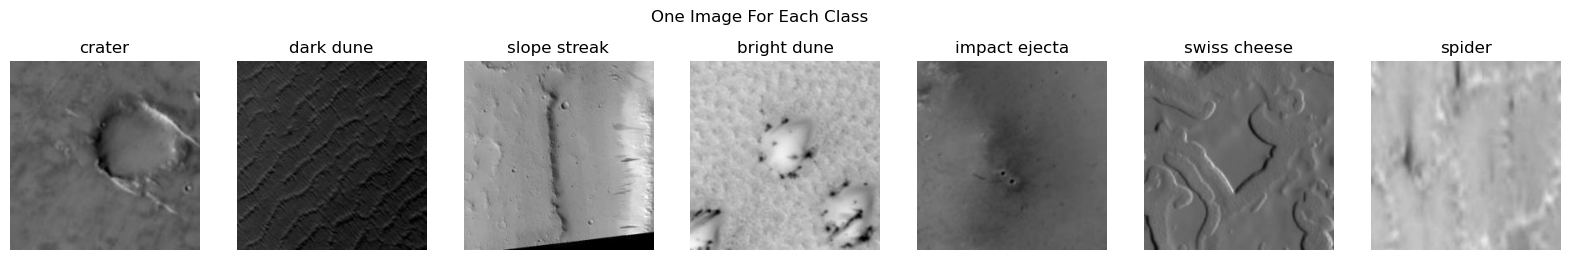

In [10]:
plot_class_samples(sample_imgs, sample_lbls)

## Feature Extraction: Edge Detection


In [56]:
#apply to all, uses canny edge detection
def extract_edges_canny(img_dataset, sigma = 1.0):
    """
    Apply Canny edge detection for feature extraction to all images
    args: img_dataset (training / val / testing dataset)
    returns: img_dataset_canny_edges (dataset of canny edges)

    """
    img_dataset_canny_edges = []
    edge_features = []
    for img in img_dataset:
        canny_edges_image = feature.canny(img[:,:,0], sigma = sigma)
        img_dataset_canny_edges.append(canny_edges_image)
        #full true false edges - regular
        edge_features.append(canny_edges_image.ravel())
        #look at counts of edges instead of where edges are
        #edge_features.append(len(np.where(canny_edges_image.ravel() == True)[0])) 
        
    
    img_dataset_canny_edges = np.array(img_dataset_canny_edges)
    edge_features = np.array(edge_features)
    return img_dataset_canny_edges, edge_features

In [61]:
def extract_edge_lengths(img_dataset):
    total_features = []
    for img in img_dataset:
        img = img[:,:,0]
        edges = cv.Canny(img, threshold1 = 100, threshold2=200)
        contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        contour_lengths = [cv.arcLength(contour, closed=False) for contour in contours]
        #agg features
        total_length = sum(contour_lengths)
        mean_length = np.mean(contour_lengths) if contour_lengths else 0
        std_length = np.std(contour_lengths) if contour_lengths else 0
        num_contours = len(contours)
        features = np.array([total_length, mean_length, std_length, num_contours])
        total_features.append(features.flatten())
    return np.array(total_features)    

In [82]:
def extract_edge_density(img_dataset):
    total_features = []
    for img in img_dataset:
        img = img[:,:,0]
        edges = cv.Canny(img, threshold1 = 100, threshold2=200)
        num_edge_pixels = np.sum(edges > 0)
        total_pixels = edges.size
        edge_density = num_edge_pixels / total_pixels
        total_features.append(edge_density)
    return np.array(total_features)    

In [103]:
def extract_edge_coords(img_dataset):
    total_features = []
    for img in img_dataset:
        img = img[:,:,0]
        edges = cv.Canny(img, threshold1=100, threshold2=200)
        y_coords, x_coords = np.where(edges > 0)
        coordinates = np.column_stack((x_coords, y_coords))

        desired_length = 1000
        if len(coordinates) > desired_length:
            # Randomly sample to reduce
            indices = np.random.choice(len(coordinates), desired_length, replace=False)
            sampled_coordinates = coordinates[indices]
        elif len(coordinates) < desired_length:
            # Pad with zeros to increase
            padding = np.zeros((desired_length - len(coordinates), 2), dtype=coordinates.dtype)
            sampled_coordinates = np.vstack((coordinates, padding))
        else:
            # Exact match
            sampled_coordinates = coordinates
        total_features.append(sampled_coordinates.flatten())
    return total_features

In [124]:
train_edges = extract_edge_coords(train_images)

In [110]:
len(train_edges[0])

2000

In [125]:
val_edges = extract_edge_coords(val_images)

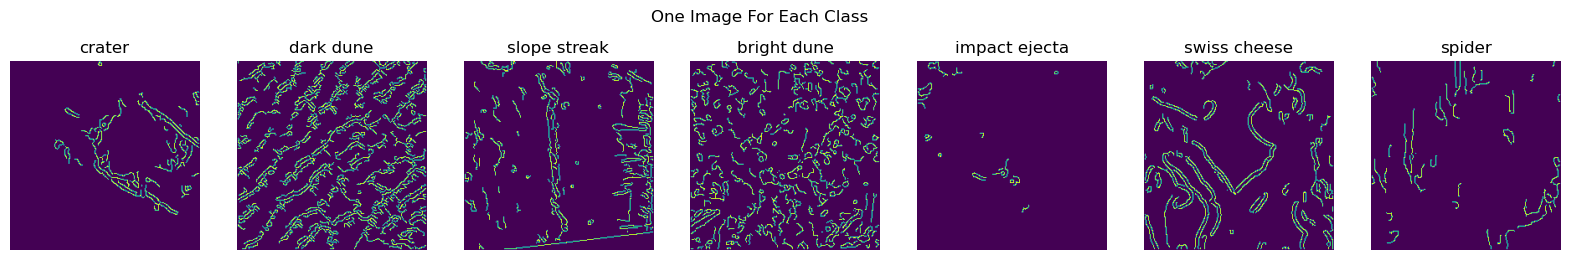

[1523 6863 3097 5382  394 3609 1321]


In [46]:
edge_samples, edge_features = extract_edges_canny(sample_imgs)
plot_class_samples(edge_samples, sample_lbls)
print(edge_features)

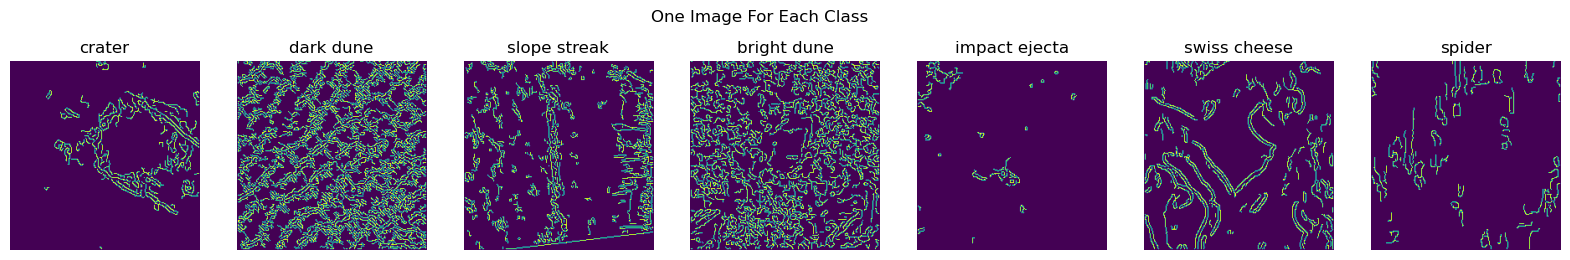

In [26]:
edge_samples, edge_features = extract_edges_canny(sample_imgs, sigma = 0.5)
plot_class_samples(edge_samples, sample_lbls)

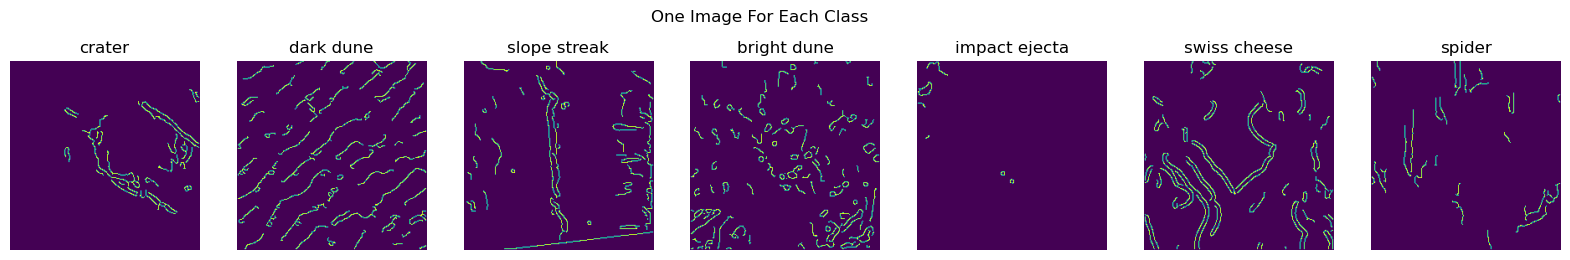

In [27]:
edge_samples, edge_features = extract_edges_canny(sample_imgs, sigma = 1.5)
plot_class_samples(edge_samples, sample_lbls)

In [57]:
simga = 1.5
_, train_edges = extract_edges_canny(train_images, sigma = simga)
_, val_edges = extract_edges_canny(val_images, sigma = simga)
_, test_edges = extract_edges_canny(test_images, sigma = simga)

In [68]:
train_edges.shape

(8960, 51529)

In [65]:
train_edges[0]

array([False, False, False, ..., False, False, False])

In [13]:
np.save(f'{feature_data_folder}/train_images_canny_edges.npy', train_edges)
np.save(f'{feature_data_folder}/val_images_canny_edges.npy', val_edges)
np.save(f'{feature_data_folder}/test_images_canny_edges.npy', test_edges)


In [74]:
len(train_edges[:,1])

8960

## Testing if distributions are clear

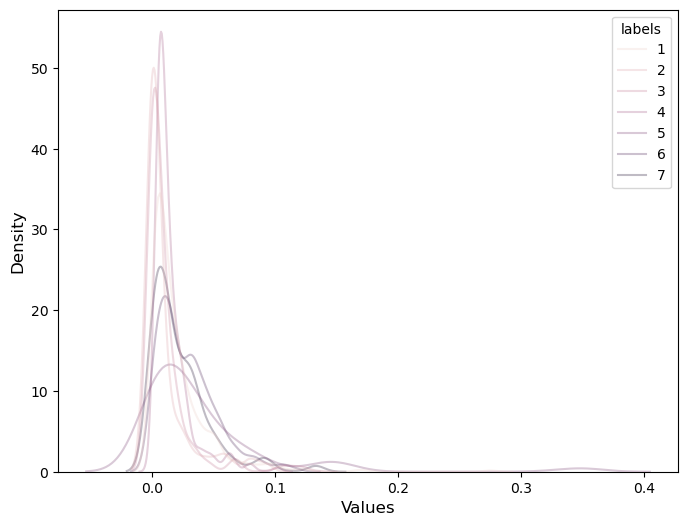

In [86]:
def plot_hist(X, y):
    #to test summary combined len edges 
    data = pd.DataFrame({'Values': X, 'labels': y})
    plt.figure(figsize = (8,6))
    sns.kdeplot(data = data, x= 'Values', hue = 'labels', common_norm = False, alpha = 0.3)
    plt.xlabel('Values', fontsize = 12)
    plt.ylabel('Density', fontsize = 12)
    plt.show()
plot_hist(train_edges, train_labels)

## PCA


In [126]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_edges)

In [127]:
pca = PCA()
pca.fit(X_scaled)

PCA()

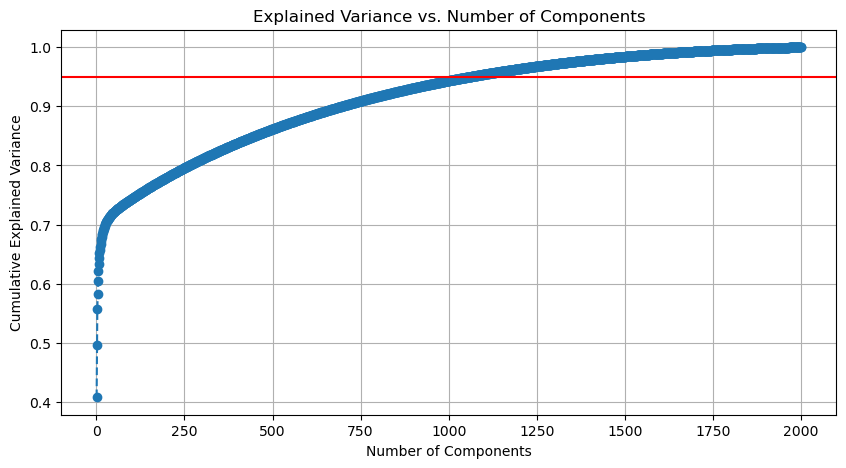

In [128]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
# draw a line at 90% of explained variance
plt.axhline(y=0.95, color='r', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [129]:
pca = PCA(n_components=1000)
pca.fit(X_scaled)

PCA(n_components=1000)

In [130]:
train_edges = pca.transform(scaler.transform(train_edges))
val_edges = pca.transform(scaler.transform(val_edges))


In [111]:
tsne = TSNE(n_components=2)
reduced_data = tsne.fit_transform(X_scaled)

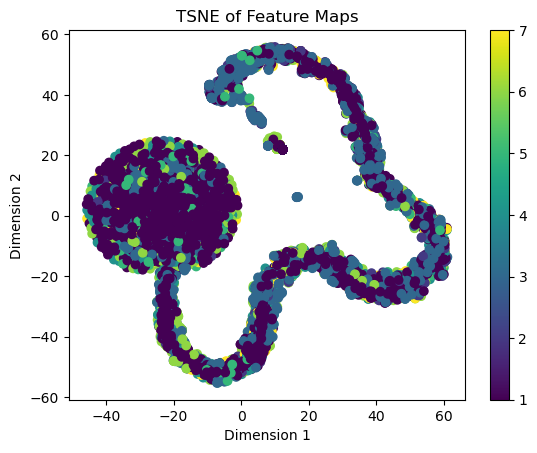

In [112]:
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=train_labels, cmap='viridis', marker='o')
plt.title('TSNE of Feature Maps')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar()
plt.show()

In [15]:
# Flatten
train_images_canny_flat = train_images_canny_edges.reshape(train_images.shape[0], -1)
# val_images_canny_flat = val_images_canny_edges.reshape(val_images.shape[0], -1)
# test_images_canny_flat = test_images_canny_edges.reshape(test_images.shape[0], -1)
print(f'Flattened images shape: {train_images_canny_flat.shape}')

print(f"Mean: {train_images_canny_flat.mean()}")
print(f"Standard Deviation: {train_images_canny_flat.std()}")
print(f"Variance: {train_images_canny_flat.var()}")


Flattened images shape: (8960, 51529)
Mean: 0.021987618622523238
Standard Deviation: 0.1466429788630632
Variance: 0.021504163249832807


In [16]:
# Standardize
scaler = StandardScaler()
train_images_canny_flat_standardized = scaler.fit_transform(train_images_canny_flat)

# PCA
pca = PCA(n_components=100)
train_images_canny_pca = pca.fit_transform(train_images_canny_flat_standardized)
print(f'PCA shape: {train_images_canny_pca.shape}')

PCA shape: (8960, 100)


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


## Predictive Power

In [131]:
clf = LogisticRegression(max_iter = 2000).fit(train_edges, train_labels)
clf.score(train_edges, train_labels)

C:\Users\linni\anaconda3\envs\comp_vision\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5833705357142858

In [132]:
clf.score(val_edges, val_labels)

0.33513879485443465

In [18]:
preds = clf.predict(train_images_canny_pca)
corr = preds == train_labels
df = pd.DataFrame({'correct': corr, 'label': train_labels})
df.head(50)


,correct,label
0,False,7
1,False,7
2,False,7
3,False,7
4,False,7
5,False,7
6,False,7
7,True,1
8,True,1
9,True,1


In [97]:
ax = sns.countplot(df, x='correct', hue='label')
ax.set_title('Correct Predictions by Label')
ax.set_xlabel('Correct')
ax.set_ylabel('Count')

NameError: name 'df' is not defined

## TSNE

In [ ]:
tsne = TSNE(n_components=2)
reduced_data = tsne.fit_transform(train_images_canny_flat_standardized)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', marker='o')
plt.title('TSNE of Feature Maps')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar()
plt.show()

## K Means
Doesn't work well for the binary numbers that make of the edges detected.

ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (7). Possibly due to duplicate points in X.

In [ ]:
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_lables = kmeans.fit_predict(train_images_canny_std)

kmeans_labels = kmeans.labels_
print(kmeans_labels)

centroids = kmeans.cluster_centers_
print(centroids)


# plt.figure(figsize=(10, 6))
# plt.scatter(train_images_canny_std[:,0], train_images_canny_std[:,1], c = kmeans_labels, cmap = 'viridis', s = 10)
# plt.title('Canny Edge Detection (Post PCA)')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.colorbar(label='Cluster')
# plt.show()